In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv('Reviews.csv')

# Show basic info
print(df.shape)
print(df.columns)
print(df.head())
print(df.info())


(568454, 10)
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0  

In [3]:
def score_to_sentiment(score):
    if score <= 2:
        return 'Negative'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Positive'

df['Sentiment'] = df['Score'].apply(score_to_sentiment)
df['Sentiment'].value_counts()


Sentiment
Positive    443777
Negative     82037
Neutral      42640
Name: count, dtype: int64

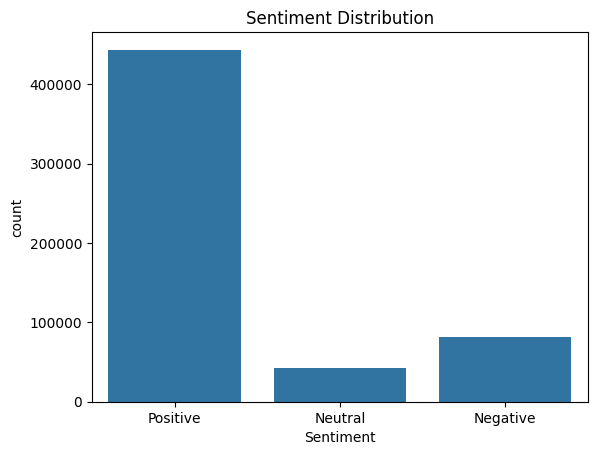

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='Sentiment', order=['Positive', 'Neutral', 'Negative'])
plt.title('Sentiment Distribution')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.preprocessing import LabelEncoder
import spacy
import warnings
warnings.filterwarnings('ignore')



class TextPreprocessor:
    
    def __init__(self, use_spacy=True):
        self.use_spacy = use_spacy
        self.label_encoder = LabelEncoder()
        
        # Try to load spaCy model, fallback to basic preprocessing if not available
        try:
            if use_spacy:
                self.nlp = spacy.load("en_core_web_sm")
                print("Using spaCy for advanced text processing")
            else:
                self.nlp = None
        except OSError:
            print("spaCy model not found. Using basic preprocessing.")
            print("To install spaCy model, run: python -m spacy download en_core_web_sm")
            self.nlp = None
            self.use_spacy = False
        
        # Basic stopwords list (commonly used words to remove)
        self.basic_stopwords = {
            'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 
            'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 
            'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 
            'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 
            'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 
            'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 
            'at', 'by', 'for', 'with', 'through', 'during', 'before', 'after', 'above', 
            'below', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 
            'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 
            'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 
            'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
            'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now'
        }
        
    def clean_text(self, text):
        """
        Clean and normalize text data
        """
        if pd.isna(text) or text == '':
            return ''
        
        # Convert to string and lowercase
        text = str(text).lower()
        
        # Remove HTML tags
        text = re.sub(r'<[^>]+>', '', text)
        
        # Remove URLs
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
        
        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)
        
        # Handle contractions (basic expansion)
        contractions = {
            "won't": "will not", "can't": "cannot", "n't": " not",
            "'re": " are", "'ve": " have", "'ll": " will",
            "'d": " would", "'m": " am", "'s": " is",
            "it's": "it is", "that's": "that is", "there's": "there is",
            "here's": "here is", "what's": "what is", "where's": "where is",
            "how's": "how is", "let's": "let us", "who's": "who is",
            "don't": "do not", "doesn't": "does not", "didn't": "did not",
            "won't": "will not", "wouldn't": "would not", "shouldn't": "should not",
            "couldn't": "could not", "mustn't": "must not"
        }
        
        for contraction, expansion in contractions.items():
            text = text.replace(contraction, expansion)
        
        # Remove numbers (optional - you might want to keep them for some analyses)
        text = re.sub(r'\d+', '', text)
        
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text)
        text = text.strip()
        
        return text
    
    def process_with_spacy(self, text):
        """
        Advanced text processing using spaCy
        """
        if text == '' or not self.use_spacy:
            return self.basic_process(text)
        
        # Process with spaCy
        doc = self.nlp(text)
        
        # Extract lemmatized tokens, removing stop words and non-alphabetic tokens
        processed_tokens = [
            token.lemma_ for token in doc 
            if not token.is_stop 
            and not token.is_punct 
            and not token.is_space 
            and token.is_alpha 
            and len(token.text) > 2
        ]
        
        return ' '.join(processed_tokens)
    
    def basic_process(self, text):
        """
        Basic text processing without spaCy
        """
        if text == '':
            return ''
        
        # Simple tokenization by splitting on whitespace
        tokens = text.split()
        
        # Remove stopwords and short tokens
        processed_tokens = [
            token for token in tokens 
            if token not in self.basic_stopwords 
            and len(token) > 2
            and token.isalpha()
        ]
        
        return ' '.join(processed_tokens)
    
    def create_sentiment_labels(self, scores):
        """
        Convert numerical scores to sentiment labels
        Score 1-2: Negative (0)
        Score 3: Neutral (1) 
        Score 4-5: Positive (2)
        """
        def score_to_sentiment(score):
            if score <= 2:
                return 0  # Negative
            elif score == 3:
                return 1  # Neutral
            else:
                return 2  # Positive
        
        return scores.apply(score_to_sentiment)
    
    def preprocess_dataframe(self, df, text_columns=['Summary', 'Text'], score_column='Score'):
        """
        Preprocess the entire dataframe
        """
        print("Starting text preprocessing...")
        
        # Create a copy to avoid modifying original data
        processed_df = df.copy()
        
        # Handle missing values in text columns
        for col in text_columns:
            if col in processed_df.columns:
                processed_df[col] = processed_df[col].fillna('')
        
        # Combine Summary and Text columns if both exist
        if 'Summary' in processed_df.columns and 'Text' in processed_df.columns:
            processed_df['combined_text'] = (
                processed_df['Summary'].astype(str) + ' ' + 
                processed_df['Text'].astype(str)
            )
        elif 'Text' in processed_df.columns:
            processed_df['combined_text'] = processed_df['Text'].astype(str)
        elif 'Summary' in processed_df.columns:
            processed_df['combined_text'] = processed_df['Summary'].astype(str)
        else:
            raise ValueError("No text columns found in the dataframe")
        
        # Clean the combined text
        print("Cleaning text data...")
        processed_df['cleaned_text'] = processed_df['combined_text'].apply(self.clean_text)
        
        # Process text (remove stopwords, lemmatize if using spaCy)
        print("Processing text (removing stopwords and normalizing)...")
        if self.use_spacy:
            processed_df['processed_text'] = processed_df['cleaned_text'].apply(self.process_with_spacy)
        else:
            processed_df['processed_text'] = processed_df['cleaned_text'].apply(self.basic_process)
        
        # Create sentiment labels from scores
        print("Creating sentiment labels...")
        processed_df['sentiment'] = self.create_sentiment_labels(processed_df[score_column])
        
        # Add sentiment label names for better interpretation
        sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
        processed_df['sentiment_label'] = processed_df['sentiment'].map(sentiment_map)
        
        # Remove rows with empty processed text
        initial_count = len(processed_df)
        processed_df = processed_df[processed_df['processed_text'].str.len() > 0]
        final_count = len(processed_df)
        
        if initial_count > final_count:
            print(f"Removed {initial_count - final_count} rows with empty processed text")
        
        # Add text length features
        processed_df['text_length'] = processed_df['processed_text'].str.len()
        processed_df['word_count'] = processed_df['processed_text'].str.split().str.len()
        
        print("Text preprocessing completed!")
        return processed_df

def load_and_preprocess_data(file_path, sample_size=None, use_spacy=False):
    """
    Load and preprocess the Amazon Fine Food Reviews dataset
    
    Args:
        file_path (str): Path to the CSV file
        sample_size (int): Number of samples to use (None for full dataset)
        use_spacy (bool): Whether to use spaCy for advanced processing
    
    Returns:
        pd.DataFrame: Preprocessed dataframe
    """
    print("Loading dataset...")
    
    try:
        # Load the dataset
        df = pd.read_csv(file_path)
        print(f"Dataset loaded with shape: {df.shape}")
    except FileNotFoundError:
        print(f"Error: Could not find the file '{file_path}'")
        print("Please check the file path and try again.")
        return None
    except Exception as e:
        print(f"Error loading file: {str(e)}")
        return None
    
    # Sample data if specified (useful for testing)
    if sample_size and sample_size < len(df):
        df = df.sample(n=sample_size, random_state=42)
        print(f"Sampled {sample_size} rows for processing")
    
    # Initialize preprocessor
    preprocessor = TextPreprocessor(use_spacy=use_spacy)
    
    # Preprocess the data
    processed_df = preprocessor.preprocess_dataframe(df)
    
    return processed_df

def save_preprocessed_data(processed_df, output_path):
    """
    Save preprocessed data to CSV file
    """
    if processed_df is None:
        print("No data to save.")
        return
    
    print(f"Saving preprocessed data to {output_path}...")
    
    # Select relevant columns for saving
    columns_to_save = [
        'Id', 'Score', 'combined_text', 'cleaned_text', 
        'processed_text', 'sentiment', 'sentiment_label',
        'text_length', 'word_count'
    ]
    
    # Only save columns that exist
    available_columns = [col for col in columns_to_save if col in processed_df.columns]
    
    try:
        processed_df[available_columns].to_csv(output_path, index=False)
        print("Preprocessed data saved successfully!")
        return True
    except Exception as e:
        print(f"Error saving file: {str(e)}")
        return False

def get_preprocessing_summary(processed_df):
    """
    Generate summary statistics of the preprocessing results
    """
    if processed_df is None:
        print("No data to summarize.")
        return
    
    print("\n" + "="*50)
    print("PREPROCESSING SUMMARY")
    print("="*50)
    
    print(f"Total samples after preprocessing: {len(processed_df)}")
    print(f"\nSentiment Distribution:")
    sentiment_counts = processed_df['sentiment_label'].value_counts()
    for sentiment, count in sentiment_counts.items():
        percentage = (count / len(processed_df)) * 100
        print(f"{sentiment}: {count} ({percentage:.1f}%)")
    
    print(f"\nText Length Statistics:")
    print(f"Average text length: {processed_df['text_length'].mean():.2f}")
    print(f"Average word count: {processed_df['word_count'].mean():.2f}")
    
    print(f"\nText Length Distribution:")
    text_stats = processed_df['text_length'].describe()
    for stat, value in text_stats.items():
        print(f"{stat}: {value:.2f}")
    
    print(f"\nSample processed texts:")
    for i, (idx, row) in enumerate(processed_df.head(3).iterrows()):
        print(f"{i+1}. Sentiment: {row['sentiment_label']}")
        print(f"   Original: {row['combined_text'][:100]}...")
        print(f"   Processed: {row['processed_text'][:100]}...")
        print()

# Example usage
if __name__ == "__main__":
    # File paths - UPDATE THESE TO MATCH YOUR FILES
    input_file = "Reviews.csv"  # Replace with your actual file path
    output_file = "preprocessed_reviews.csv"
    
    # Load and preprocess data
    # Set use_spacy=True if you have spaCy installed, otherwise it will use basic processing
    processed_data = load_and_preprocess_data(
        input_file, 
        sample_size=10000,  # Remove this line to process full dataset
        use_spacy=False  # Set to True if you have spaCy installed
    )
    
    if processed_data is not None:
        # Get preprocessing summary
        get_preprocessing_summary(processed_data)
        
        # Save preprocessed data
        success = save_preprocessed_data(processed_data, output_file)
        
        if success:
            print("\n" + "="*50)
            print("PREPROCESSING COMPLETE!")
            print("="*50)
            print(f"Preprocessed data saved to: {output_file}")
            print("You can now proceed with feature engineering and model training.")
        else:
            print("Failed to save preprocessed data.")
    else:
        print("Preprocessing failed. Please check your input file.")

# Alternative minimal preprocessing (if you want to keep it simple)
def simple_preprocessing(df, sample_size=1000):
    """
    Very basic preprocessing without external dependencies
    """
    print("Using simple preprocessing...")
    
    # Sample the data
    if sample_size and sample_size < len(df):
        df = df.sample(n=sample_size, random_state=42)
    
    # Basic text cleaning
    df['combined_text'] = df['Summary'].fillna('') + ' ' + df['Text'].fillna('')
    df['cleaned_text'] = df['combined_text'].str.lower()
    df['cleaned_text'] = df['cleaned_text'].str.replace(r'[^\w\s]', ' ', regex=True)
    df['cleaned_text'] = df['cleaned_text'].str.replace(r'\s+', ' ', regex=True)
    
    # Create sentiment labels
    df['sentiment'] = df['Score'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))
    df['sentiment_label'] = df['sentiment'].map({0: 'Negative', 1: 'Neutral', 2: 'Positive'})
    
    return df[['Id', 'Score', 'cleaned_text', 'sentiment', 'sentiment_label']]